In [1]:
# UNIVERSIDAD LATINA DE PANAMÁ - 2024-1 / INTELIGENCIA ARTIFICIAL

#Laboratorio No.3
#GRUPO 3: Getsie Sayas, Iván González 

In [2]:
# Instalamos esta dependencia que es necesaria en un punto
!pip install pillow
!pip install opencv-python

In [3]:
#Listado de Librerías

import pandas as pd
import numpy as np
import os
import tempfile
import PIL

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from urllib.request import urlretrieve
from zipfile import ZipFile
from PIL import Image 
from numpy.random import randint

In [4]:
# Para tener repitividad en los resultados generados

np.random.seed(42)

# Creamos un directorio temporal
d = tempfile.mkdtemp()

# Definimos el URL
url = 'https://github.com/GJSayas/leave_leaves/blob/main/Plants_2.zip'

# Tenemos la data
fn, info = urlretrieve(url, os.path.join(d, 'Plants_2.zip'))


In [5]:
print("[INFO] Creada carpeta temporal en:", fn)
print("[INFO] Mi directorio actual de trabajo es:", os.getcwd())

[INFO] Creada carpeta temporal en: C:\Users\ASUS\AppData\Local\Temp\tmph6qmelx3\Plants_2.zip
[INFO] Mi directorio actual de trabajo es: C:\Users\ASUS\Documents\ULATINA\2024-1\IA\LABS


In [7]:
#Creación de carpeta para contenido del ZIP con plantas

myimagedir = os.path.join(os.getcwd(), 'DATASETS\LAB 3\Leaves') 
if not os.path.exists(myimagedir):
    os.mkdir(myimagedir)

file_name='DATASETS\LAB 3\Plants_2.zip'

with ZipFile(file_name, 'r') as zip: 
    zip.extractall(path=myimagedir, members=None,)
    zip.close()

In [8]:
#Remover el directorio temporal 
os.remove(fn)
os.rmdir(d)

In [9]:
#Separación de las imágenes a utilizar del dataset, la carpeta "images to predict"

img_predict= 'DATASETS\LAB 3\Leaves\Plants_2\images to predict'
jpeglist = os.listdir(img_predict)

i = 0
with open('labels.txt', 'w') as lbl:
    for _r in jpeglist:
        i = i + 1
        if i <= 66:
            leafclass = 0
        if i > 66 and i <= 126:
            leafclass = 1
        if i > 126:
            leafclass = 2
        lbl.write(str(leafclass) + '\n')
lbl.close()

In [10]:
## I. LEAF DATASET:

#Conteo de la cantidad de imágenes a utilizar

target = np.genfromtxt('labels.txt').astype(np.uint8)
target.shape

(180,)

In [12]:
#Primer procesamiento de imágenes convirtiéndolo en una arreglo con imágenes de dimensiones 896x592 y 3 canales

w       = 896
h       = 597
nimages = 180
nchan   = 3

imgarr   = np.zeros((w*h*nchan, nimages), dtype=np.uint8)

for index, filename in enumerate(os.listdir(img_predict)):
    img = PIL.Image.open(os.path.join(img_predict, filename))
    pixels = np.array(img).reshape(w*h*nchan)
    imgarr[:, index] = pixels
    

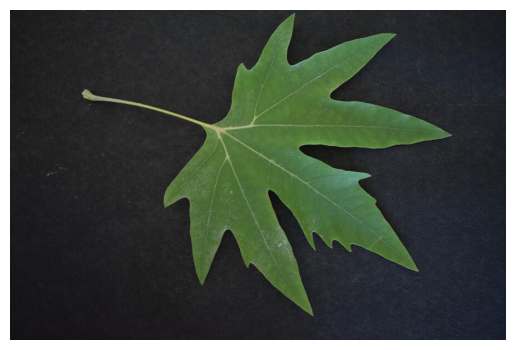

In [13]:
# Ahora imprimiremos una hoja aleatorea :D

some_leaf = imgarr[:, randint(0, 180)].reshape(597, 896, 3)
plt.imshow(some_leaf)
plt.axis("off")

plt.show()

In [14]:
# Por convenencia dividimos en tres clases iguales de mismo tamaño.
# Como todas las clases tendrán la misma cantidad de datos, vamos a emparejarlas solamente para poder dividir mejor el dataset

X = imgarr
Y = target
Y = np.hstack((Y[:60], Y[66:]))
X = np.hstack((X[:, :60], X[:, 66:]))
X.shape, Y.shape

((1604736, 174), (174,))

In [15]:
# Dividimos ahora el training set y el test set
nimginclass = 60
train = int(0.8*60)
test = 60 - train

# La primera clase va de 0 a 48, la segunda de 60 a 119 y la ultima de 120 a 180
# Sin embargo son de 0 a 47 imagenes de training y de 48 a 59 para test para cada clase

Xtrain = np.hstack((X[:,   :48], X[:, 60:(60+48)], X[:, 120:(120+48)]))/255
Ytrain = np.hstack((Y[:48], Y[60:(60+48)], Y[120:(120+48)]))

Xtest  = np.hstack((X[:, 48:(48+12)], X[:, (60+48):(60+48+12)], X[:, (120+48):]))/255
Ytest  = np.hstack((Y[48:(48+12)], Y[(60+48):(60+48+12)], Y[(120+48):]))

#Imprimimos las divisiones como verificación 

Xtrain.shape, Xtest.shape, Ytrain.shape, Ytest.shape

((1604736, 144), (1604736, 30), (144,), (30,))

In [16]:
#II. Clasificación Multiclase

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, random_state=42)
sgd_clf.fit(Xtrain.T, Ytrain)

C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


SGDClassifier(max_iter=5, random_state=42)

In [17]:
#Impresión de las predicciones respecto al test 

Ypredict = sgd_clf.predict(Xtest.T)
Ypredict, Ytest

(array([2, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0,
        0, 2, 2, 2, 0, 2, 0, 2], dtype=uint8),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 2, 2, 2, 2, 2, 2], dtype=uint8))

In [18]:
#Ahora utilizaremos una métrica para el rendimiento de la predicción llamada validación cruzada. 
#Esta función evalua el modelo utilizado usando validación cruzada con k-fold

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

kfold = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for xindex, yindex in kfold.split(Xtrain.T, Ytrain):
    clonemodel  = clone(sgd_clf)
    Xtrainfold = Xtrain.T[xindex]
    Ytrainfold = (Ytrain[xindex])
    Xtestfold  = Xtrain.T[yindex]
    Ytestfold  = (Ytrain[yindex])

    clonemodel.fit(Xtrainfold, Ytrainfold)
    prediction = clonemodel.predict(Xtestfold)
    numok = sum(prediction == Ytestfold)
    print(numok / len(prediction))
    

C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


0.3541666666666667


C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


0.4166666666666667


C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


0.5833333333333334


In [20]:
#Visto con la métrica de cross_validation para observar que tan bien o mal lo hizo nuestro dataset.

cross_val_score(sgd_clf, Xtrain.T, Ytrain, cv=3, scoring="accuracy")


C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


array([0.52083333, 0.41666667, 0.35416667])

In [24]:
#Evaluación del modelo en base a la matriz de confusión.

from sklearn.metrics import confusion_matrix

Ypredictions = cross_val_predict(sgd_clf, Xtrain.T, Ytrain, cv=3)

confMat = confusion_matrix(Ytrain, Ypredictions)
confMat

C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


array([[20, 26,  2],
       [ 6, 35,  7],
       [12, 29,  7]], dtype=int64)

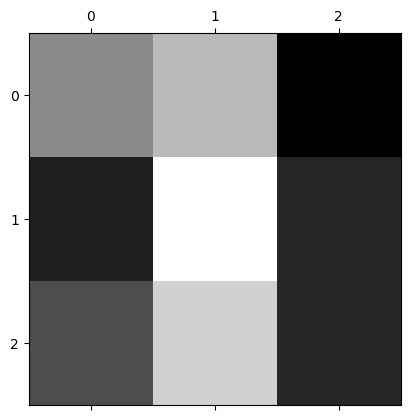

In [25]:
#Visto con colores...

plt.matshow(confMat, cmap=plt.cm.gray)
plt.show()

In [26]:
#MÉTRICAS DE CLASIFICACIÓN BINARIA

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

precision_score(Ytrain, Ypredictions, average='micro')

0.4305555555555556

In [27]:
recall_score(Ytrain, Ypredictions, average='micro')

0.4305555555555556

In [28]:
f1_score(Ytrain, Ypredictions, average='micro')

0.4305555555555556